# Add Public Raster Dataset

In [1]:
from datetime import datetime

import geoengine_openapi_client

import geoengine as ge
from geoengine.types import RasterBandDescriptor

## Initialize Geo Engine as Admin

In [2]:
ge.initialize("http://localhost:3030/api", ("admin@localhost", "adminadmin"))

## List volumes

In [3]:
volumes = ge.volumes()
volumes

[Volume(name='test_data', path='test_data/')]

## Define metadata

In [4]:
file_path = "raster/landcover/landcover.tif"  # specify file path relative to volume path

rasterband_channel = 1

origin = [-180.0, 90.0]
x_pixel_size = 0.1
y_pixel_size = -0.1


width = 3600
height = 1800

file_not_found_handling = geoengine_openapi_client.FileNotFoundHandling.NODATA

gdal_params = geoengine_openapi_client.GdalDatasetParameters.from_dict(
    {
        "filePath": file_path,
        "rasterbandChannel": rasterband_channel,
        "geoTransform": {
            "originCoordinate": {"x": origin[0], "y": origin[1]},
            "xPixelSize": x_pixel_size,
            "yPixelSize": x_pixel_size,
        },
        "width": width,
        "height": height,
        "fileNotFoundHandling": file_not_found_handling,
        "noDataValue": None,
        "propertiesMapping": None,
        "gdalOpenOptions": None,
        "gdalConfigOptions": None,
        "allowAlphabandAsMask": True,
    }
)

result_descriptor_measurement = ge.ClassificationMeasurement(
    measurement="Land Cover",
    classes={
        0: "Water Bodies",
        1: "Evergreen Needleleaf Forests",
        2: "Evergreen Broadleaf Forests",
        3: "Deciduous Needleleaf Forests",
        4: "Deciduous Broadleleaf Forests",
        5: "Mixed Forests",
        6: "Closed Shrublands",
        7: "Open Shrublands",
        8: "Woody Savannas",
        9: "Savannas",
        10: "Grasslands",
        11: "Permanent Wtlands",
        12: "Croplands",
        13: "Urban and Built-Up",
        14: "Cropland-Natural Vegetation Mosaics",
        15: "Snow and Ice",
        16: "Barren or Sparsely Vegetated",
    },
)


result_descriptor = ge.RasterResultDescriptor(
    "U8",
    [RasterBandDescriptor("band", result_descriptor_measurement)],
    "EPSG:4326",
    spatial_grid=ge.SpatialGridDescriptor(
        descriptor=geoengine_openapi_client.SpatialGridDescriptorState.SOURCE,
        spatial_grid=ge.SpatialGridDefinition(
            geo_transform=ge.GeoTransform(x_min=-180.0, y_max=90.0, x_pixel_size=0.1, y_pixel_size=-0.1),
            grid_bounds=ge.GridBoundingBox2D(
                top_left_idx=ge.GridIdx2D(x_idx=0, y_idx=0), bottom_right_idx=ge.GridIdx2D(x_idx=3599, y_idx=1799)
            ),
        ),
    ),
    time=ge.TimeDescriptor(dimension=ge.IrregularTimeDimension(), bounds=None)
)

meta_data = geoengine_openapi_client.GdalMetaDataStatic.from_dict(
    {
        "type": "GdalStatic",
        "time": None,
        "params": gdal_params,
        "resultDescriptor": result_descriptor.to_api_dict().to_dict(),
    }
)

meta_data

GdalMetaDataStatic(cache_ttl=None, params=GdalDatasetParameters(allow_alphaband_as_mask=True, file_not_found_handling=<FileNotFoundHandling.NODATA: 'NoData'>, file_path='raster/landcover/landcover.tif', gdal_config_options=None, gdal_open_options=None, geo_transform=GdalDatasetGeoTransform(origin_coordinate=Coordinate2D(x=-180.0, y=90.0), x_pixel_size=0.1, y_pixel_size=0.1), height=1800, no_data_value=None, properties_mapping=None, rasterband_channel=1, width=3600), result_descriptor=RasterResultDescriptor(bands=[RasterBandDescriptor(measurement=Measurement(oneof_schema_1_validator=None, oneof_schema_2_validator=None, oneof_schema_3_validator=None, actual_instance=ClassificationMeasurement(classes={'0': 'Water Bodies', '1': 'Evergreen Needleleaf Forests', '2': 'Evergreen Broadleaf Forests', '3': 'Deciduous Needleleaf Forests', '4': 'Deciduous Broadleleaf Forests', '5': 'Mixed Forests', '6': 'Closed Shrublands', '7': 'Open Shrublands', '8': 'Woody Savannas', '9': 'Savannas', '10': 'Gras

In [5]:
add_dataset_properties = ge.AddDatasetProperties(
    name="MCD12C1",
    display_name="Land Cover",
    source_operator="GdalSource",
    description="Land Cover",
    symbology=ge.RasterSymbology(
        opacity=1.0,
        raster_colorizer=ge.SingleBandRasterColorizer(
            band=0,
            band_colorizer=ge.LinearGradientColorizer(
                breakpoints=[
                    ge.ColorBreakpoint(value=0, color=(0, 0, 255, 255)),
                    ge.ColorBreakpoint(value=8, color=(0, 255, 0, 255)),
                    ge.ColorBreakpoint(value=16, color=(255, 0, 0, 255)),
                ],
                no_data_color=(0, 0, 0, 0),
                over_color=(0, 0, 0, 0),
                under_color=(0, 0, 0, 0),
            ),
        ),
    ),
    provenance=[
        ge.Provenance(
            citation="The data was obtained from <https://lpdaac.usgs.gov/products/mcd12c1v006>. \
            The layer Majority_Land_Cover_Type_1 was extracted, downscaled and saved as landcover.tif.",
            uri="https://lpdaac.usgs.gov/products/mcd12c1v006/",
            license="All data distributed by the LP DAAC contain no restrictions on the data reuse. (https://lpdaac.usgs.gov/resources/faqs/#am-i-allowed-to-reuse-lp-daac-data).",
        )
    ],
)

add_dataset_properties.to_api_dict()

AddDataset(description='Land Cover', display_name='Land Cover', name='MCD12C1', provenance=[Provenance(citation='The data was obtained from <https://lpdaac.usgs.gov/products/mcd12c1v006>.             The layer Majority_Land_Cover_Type_1 was extracted, downscaled and saved as landcover.tif.', license='All data distributed by the LP DAAC contain no restrictions on the data reuse. (https://lpdaac.usgs.gov/resources/faqs/#am-i-allowed-to-reuse-lp-daac-data).', uri='https://lpdaac.usgs.gov/products/mcd12c1v006/')], source_operator='GdalSource', symbology=Symbology(oneof_schema_1_validator=None, oneof_schema_2_validator=None, oneof_schema_3_validator=None, oneof_schema_4_validator=None, actual_instance=RasterSymbology(opacity=1.0, raster_colorizer=RasterColorizer(oneof_schema_1_validator=None, oneof_schema_2_validator=None, actual_instance=SingleBandRasterColorizer(band=0, band_colorizer=Colorizer(oneof_schema_1_validator=None, oneof_schema_2_validator=None, oneof_schema_3_validator=None, ac

## Add raster dataset to the "test_data" volume

In [6]:
volume = ge.volume_by_name("test_data")

dataset_name = ge.add_dataset(
    volume,
    add_dataset_properties,
    geoengine_openapi_client.MetaDataDefinition(
        meta_data,
    ),
)

dataset_name

MCD12C1

## Lookup dataset in listing

In [7]:
for d in ge.datasets.list_datasets():
    print(d)

description='Boundaries of Germany' display_name='Germany' id=UUID('e28e4183-9fc1-4431-be43-c094e819d569') name='germany_outline' result_descriptor=TypedResultDescriptor(oneof_schema_1_validator=None, oneof_schema_2_validator=None, oneof_schema_3_validator=None, actual_instance=TypedVectorResultDescriptor(bbox=BoundingBox2D(lower_left_coordinate=Coordinate2D(x=5.85248986800011, y=47.2711209110001), upper_right_coordinate=Coordinate2D(x=15.022059367000098, y=55.0653343770001)), columns={}, data_type=<VectorDataType.MULTIPOLYGON: 'MultiPolygon'>, spatial_reference='EPSG:4326', time=TimeInterval(end=8210266876799999, start=-8334601228800000), type='vector'), one_of_schemas={'TypedPlotResultDescriptor', 'TypedRasterResultDescriptor', 'TypedVectorResultDescriptor'}, discriminator_value_class_map={}) source_operator='OgrSource' symbology=None tags=[]
description='Land Cover derived from MODIS/Terra+Aqua Land Cover' display_name='Land Cover' id=UUID('76695309-3b13-4571-8dba-bb48891eabd8') nam

## Verify that data is accessible for user

In [8]:
ge.reset()
ge.initialize("http://localhost:3030/api")

workflow = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "GdalSource",
            "params": {
                "data": "MCD12C1",
            },
        },
    }
)

workflow.get_result_descriptor()

Data type:         U8
Spatial Reference: EPSG:4326
Spatial Grid: SpatialGridDescriptor(spatial_grid=SpatialGridDefinition(geo_transform=Origin: (-180.0, 90.0), X Pixel Size: 0.1, Y Pixel Size: -0.1, grid_bounds=GridBoundingBox2D(top_left_idx=GridIdx2D(x_idx=0, y_idx=0), bottom_right_idx=GridIdx2D(x_idx=3599, y_idx=1799))), descriptor=<SpatialGridDescriptorState.SOURCE: 'source'>) 
Time Bounds: None
Bands:
    band: Land Cover (0: Water Bodies, 1: Evergreen Needleleaf Forests, 2: Evergreen Broadleaf Forests, 3: Deciduous Needleleaf Forests, 4: Deciduous Broadleleaf Forests, 5: Mixed Forests, 6: Closed Shrublands, 7: Open Shrublands, 8: Woody Savannas, 9: Savannas, 10: Grasslands, 11: Permanent Wtlands, 12: Croplands, 13: Urban and Built-Up, 14: Cropland-Natural Vegetation Mosaics, 15: Snow and Ice, 16: Barren or Sparsely Vegetated)

## Load the data

/home/droenner/git/geoengine-python/.venv/lib/python3.12/site-packages/owslib/coverage/wcs110.py:86: FutureWarning: Truth-testing of elements was a source of confusion and will always return True in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


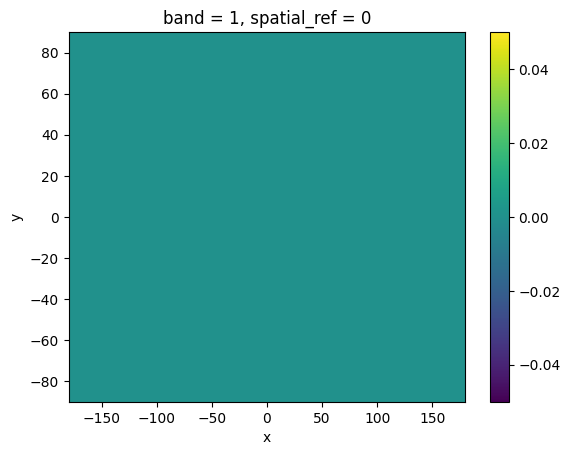

In [9]:
time = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")

data = workflow.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
    ),
    spatial_resolution=ge.SpatialResolution(10.0, 10.0),
)

data.plot()

## Delete the dataset

In [10]:
ge.reset()
ge.initialize("http://localhost:3030/api", ("admin@localhost", "adminadmin"))

ge.delete_dataset(dataset_name)

## Verify the dataset was deleted

In [11]:
try:
    data = workflow.get_xarray(
        ge.QueryRectangle(
            ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
            ge.TimeInterval(time, time),
        ),
        spatial_resolution=ge.SpatialResolution(360.0 / 16, 180.0 / 16),
    )
except Exception as e:
    print(e)

{"error":"UnknownDatasetName","message":"Dataset name 'MCD12C1' does not exist"}


/home/droenner/git/geoengine-python/.venv/lib/python3.12/site-packages/owslib/coverage/wcs110.py:86: FutureWarning: Truth-testing of elements was a source of confusion and will always return True in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa
